# Application: Dynamic analysis in human limb cell development

In this notebook, we will use the `ModelComparison` module from `regvelo` to evaluate different model training strategies. Using the best-performing model, we further demonstrate an in-silico perturbation analysis. The dataset used here is a subset of the human embryonic limb data from [Zhang, B. et al, 2024](https://www.nature.com/articles/s41586-023-06806-x), in which the authors profiled single-cell gene expression across post-conception weeks (PCW) 5 to 9. For our analysis, we focus specifically on cells from the lower limb that are involved in myogenic differentiation.


Using the selected model, we simulate transcription factor (TF) perturbations by removing all regulatory influences of the targeted TFs and generating the corresponding perturbed velocity fields. To quantify the impact of these perturbations, we compute the depletion likelihood as defined in [Wang, W. et al, 2024](https://doi.org/10.1101/2024.12.11.627935). Additionally, we assess short-term perturbation effects by performing stochastic simulations of cell transitions under both the unperturbed and perturbed velocity fields.

## Library import

In [1]:
# Basic packages
import numpy as np
import pandas as pd
import scipy
import torch
import matplotlib.pyplot as plt
import mplscience
import seaborn as sns
from scipy.stats import ttest_ind

# RegVelo and related package
import scanpy as sc
import cellrank as cr
import scvi
import scvelo as scv
import regvelo as rgv
from regvelo import REGVELOVI
from regvelo import ModelComparison # Import ModelComparison

## General settings and helper functions

In [2]:
scvi.settings.seed = 0

[rank: 0] Seed set to 0


In [3]:
scv.settings.verbosity = 3
cr.settings.verbosity = 2

In [4]:
%matplotlib inline

In [5]:
plt.rcParams["svg.fonttype"] = "none"
scv.settings.set_figure_params("scvelo", dpi=80, transparent=True, fontsize=14, color_map="viridis")

In [6]:
from typing import Dict, List, Tuple
import anndata
from matplotlib.axis import Axis

def add_significance(
    ax: Axis, left: int, right: int, significance: str, level: int = 0, orientation: str = "horizontal", **kwargs
) -> None:
    """Add significance bracket to Matplotlib Axis plot.

    Parameters
    ----------
    ax
        Matplotlib axis.
    left
        Position of left (top) subplot.
    right
        Position of right (bottom) subplot.
    siginifcance
        Significance ID to plot.
    level
        Level of bracket.
    orientation
        Orientation of bracket.
    **kwargs
        Keyword arguments passed to Axis.plot and to specify bracket level (`bracket_level`) and height
        (`bracket_height`), and distance between text and bracket (`text_height`).

    Returns
    -------
    None.
    """
    bracket_level = kwargs.pop("bracket_level", 1)
    bracket_height = kwargs.pop("bracket_height", 0.02)
    text_height = kwargs.pop("text_height", 0.01)

    if orientation == "horizontal":
        bottom, top = ax.get_ylim()
    else:
        bottom, top = ax.get_xlim()
    axis_range = top - bottom

    bracket_level = (axis_range * 0.07 * level) + top * bracket_level
    bracket_height = bracket_level - (axis_range * bracket_height)

    if orientation == "horizontal":
        ax.plot([left, left, right, right], [bracket_height, bracket_level, bracket_level, bracket_height], **kwargs)
        ax.text(
            (left + right) * 0.5,
            bracket_level + (axis_range * text_height),
            significance,
            ha="center",
            va="bottom",
            c="k",
        )
    else:
        ax.plot([bracket_height, bracket_level, bracket_level, bracket_height], [left, left, right, right], **kwargs)
        ax.text(
            bracket_level + (axis_range * text_height),
            (left + right) * 0.5,
            significance,
            va="center",
            ha="left",
            c="k",
            rotation=-90,
        )

## Load data
In this section, we load the limb development dataset described previously. The dataset contains 12207 cells and 606 genes. Celltype annotation are available in `.obs['leiden_R_celltype']`, including *PAX7+MyoProg1*, *PAX7+MyoProg2*, *MyoB2*, *PAX3+PAX7+MyoProg*, *MyoC2*, *PAX3+MyoProg*, *MyoC1*, *MyoB1*, *MYL3+MyoC*, and *MYH3+MyoC* cells. 

The list of transcription factors (TFs) is stored in `.var['TF']`. 

To evaluate model performance, we use the developmental stage number as ground truth for assessing the inferred latent time. This reference is later set via the argument `side_information='Real_Time'`.

In [7]:
adata = rgv.datasets.human_limb()
adata

AnnData object with n_obs × n_vars = 12207 × 606
    obs: 'percent_mito', 'n_counts', 'n_genes', 'doublet_scores', 'bh_pval', 'adj_stage', 'adj_sample', 'leiden', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'leiden_R_celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'velocity_genes', 'TF'
    uns: 'adj_stage_colors', 'celltype_sizes', 'diffmap_evals', 'draw_graph', 'leiden', 'leiden_R_celltype_colors', 'leiden_R_colors', 'leiden_sizes', 'log1p', 'marker_m_leiden_R_celltype', 'neighbors', 'network', 'paga', 'pca', 'phase_colors', 'rank_genes_groups', 'regulators', 'skeleton', 'targets', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

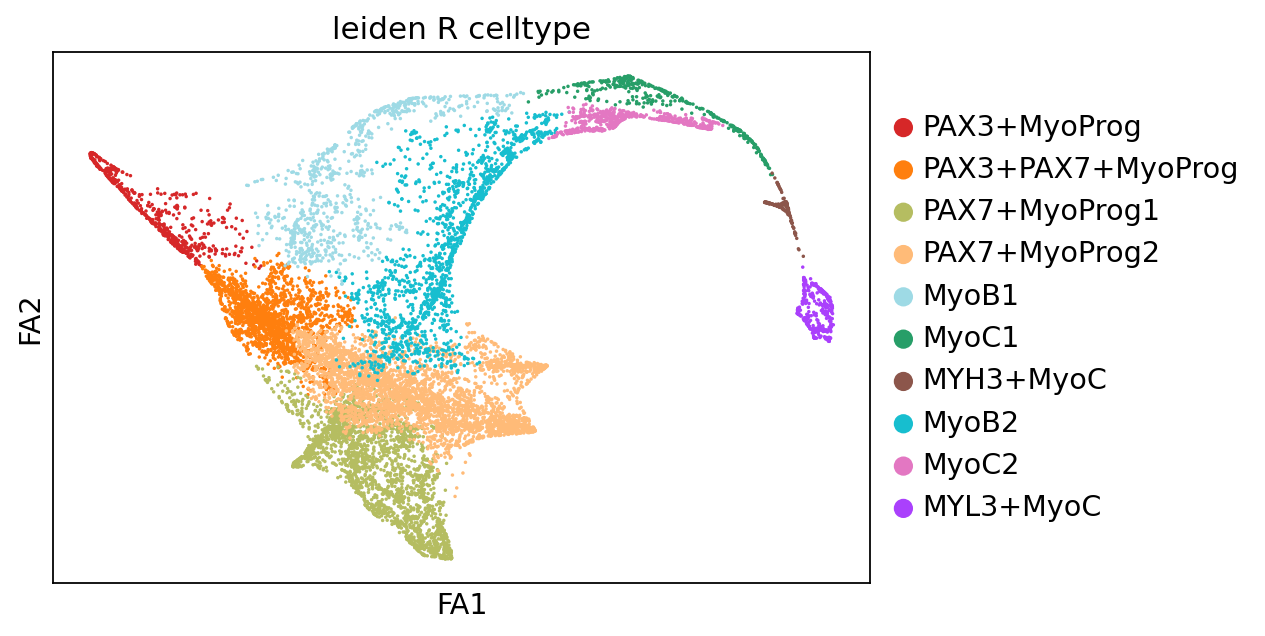

In [8]:
sc.pl.scatter(adata, basis="draw_graph_fa", color="leiden_R_celltype")

In [9]:
# infer Real_Time key
adata.obs['adj_stage_num'] = adata.obs['adj_stage'].str.replace('Pcw', '').astype(float)
adata.uns['skeleton'] = adata.uns['skeleton'].astype(np.float32)
adata

AnnData object with n_obs × n_vars = 12207 × 606
    obs: 'percent_mito', 'n_counts', 'n_genes', 'doublet_scores', 'bh_pval', 'adj_stage', 'adj_sample', 'leiden', 'S_score', 'G2M_score', 'phase', 'leiden_R', 'leiden_R_celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'adj_stage_num'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_ids', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'velocity_genes', 'TF'
    uns: 'adj_stage_colors', 'celltype_sizes', 'diffmap_evals', 'draw_graph', 'leiden', 'leiden_R_celltype_colors', 'leiden_R_colors', 'leiden_sizes', 'log1p', 'marker_m_leiden_R_celltype', 'neighbors', 'network', 'paga', 'pca', 'phase_colors', 'rank_genes_groups', 'regulators', 'skeleton', 'targets', 'umap'
    obsm: 'X_diffmap', 'X_draw_graph_fa', 'X_pca', 'X_umap'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

## Model Comparison
In the following section, we compare different model training strategies, i.e. *soft*, *hard*, and *soft_regularized* modes under the same normalization factor. Model performance is evaluated using real developmental time as side information (`side_information = 'Real_time'`).

We first define the set of terminal states, which includes *PAX7+MyoProg1*, *MYH3+MyoC*, and *MYL3+MyoC* cells. Additionally, we set `n_states=8`.

In [10]:
TERMINAL_STATES = ["PAX7+MyoProg1", "MYH3+MyoC", "MYL3+MyoC"]
n_STATES = 8

In [11]:
comp = ModelComparison(adata = adata,terminal_states=TERMINAL_STATES, n_states=n_STATES)
comp.train(model_list=['soft','hard','soft_regularized'],
           lam2=[1.0],
           n_repeat=3)

[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/li

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.
[rank: 0] Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

[rank: 0] Seed set to 2


Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1754.909. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_co

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.
[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

[rank: 0] Seed set to 1


Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1718.788. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_co

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

[rank: 0] Seed set to 2


Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1734.265. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_co

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.
[rank: 0] Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

[rank: 0] Seed set to 1


Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1524.247. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_co

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1500` reached.
[rank: 0] Seed set to 2


Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1505.458. Signaling Trainer to stop.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
/home/icb/yifan.chen/miniconda3/envs/regvelo-py310-v2/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_co

Training:   0%|          | 0/1500 [00:00<?, ?it/s]

Monitored metric elbo_validation did not improve in the last 45 records. Best score: -1310.308. Signaling Trainer to stop.


['soft_0',
 'soft_1',
 'soft_2',
 'hard_0',
 'hard_1',
 'hard_2',
 'soft_regularized\nlam2:1.0_0',
 'soft_regularized\nlam2:1.0_1',
 'soft_regularized\nlam2:1.0_2']

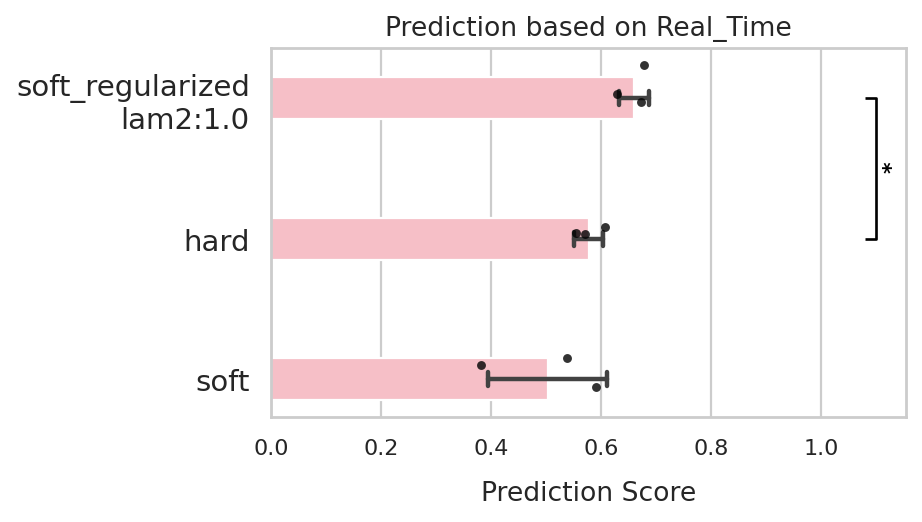

In [12]:
comp.evaluate(side_information='Real_Time',
              side_key='adj_stage_num')
comp.plot_results(side_information='Real_Time')

In [13]:
comp.df_Real_Time

Model      Corr Run
0                        soft  0.537389   0
1                        soft  0.590243   1
2                        soft  0.381020   2
3                        hard  0.570352   0
4                        hard  0.554766   1
5                        hard  0.606984   2
6  soft_regularized\nlam2:1.0  0.629149   0
7  soft_regularized\nlam2:1.0  0.678848   1
8  soft_regularized\nlam2:1.0  0.672296   2

Based on the results, we can see that the best-performing model is the soft_regularized mode, which achieves the highest prediction score while maintaining good stability across runs. We therefore use this model to demonstrate the following perturbation analysis.

In [14]:
vae_sr0 = comp.MODEL_TRAINED['soft_regularized\nlam2:1.0_0']
vae_sr0.save('vae_sr0')

## In silico perturbation
In the following analysis, we sequentially knock down two TFs, *MSC* and *MYOG*, to examine their effects on cell fate determination. Musculin (MSC) is identified as an important transcriptional repressor that maintains muscle stem cell identity, while MYOG gene promotes terminal differentiation [Zhang, B. et al, 2024](https://www.nature.com/articles/s41586-023-06806-x).

For each TF, we use RegVelo's `rgv.tl.in_silico_block_simulation` function to remove its regulatory effects from the best-performing model and generate the corresponding perturbed velocity field.

In [15]:
# Reload selected model
vae_sr0 = REGVELOVI.load('vae_sr0', adata)
rgv.tl.set_output(adata, vae_sr0, n_samples=30, batch_size=adata.n_obs)

INFO     File vae_sr0/model.pt already downloaded                                                                  


In [16]:
# Computing states transition probability
vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
estimator = cr.estimators.GPCCA(0.8*vk + 0.2*ck)
estimator.compute_macrostates(n_states=n_STATES, cluster_key='leiden_R_celltype')
estimator.set_terminal_states(TERMINAL_STATES)
estimator.compute_fate_probabilities()

Computing transition matrix using `'deterministic'` model


  0%|          | 0/12207 [00:00<?, ?cell/s]

Using `softmax_scale=10.3188`


  0%|          | 0/12207 [00:00<?, ?cell/s]

    Finish (0:00:32)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing Schur decomposition
When computing macrostates, choose a number of states NOT in `[8]`
Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:17)
Computing `9` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:06)
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing fate probabilities


  0%|          | 0/3 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


In [17]:
adata_pert_dict = {}
TF_list = ['MSC','MYOG']
MODEL = 'vae_sr0'
for TF in TF_list:
    adata_target_pert, reg_vae_pert = rgv.tl.in_silico_block_simulation(model=MODEL,
                                                                        adata=adata,
                                                                        TF=TF,
                                                                        cutoff=0)
    adata_pert_dict[TF] = adata_target_pert

INFO     File vae_sr0/model.pt already downloaded                                                                  
INFO     File vae_sr0/model.pt already downloaded                                                                  


### Long-term perturbation effect (Depletion likelihood based on cell fate probabilities)
We assess the perturbation effects on cell fate decisions by passing the perturbed velocity estimates into CellRank's `VelocityKernel`. To quantify the impact on terminal cell states, we compute depletion scores using `rgv.mt.depletion_score` and visualize the results using `rgv.pl.depletion_score`.

In [18]:
ct_indices = {
    ct: adata.obs["term_states_fwd"][adata.obs["term_states_fwd"] == ct].index.tolist()
    for ct in TERMINAL_STATES}

# Computing states transition probability for perturbed systems
for TF, adata_target_perturb in adata_pert_dict.items():
    vk = cr.kernels.VelocityKernel(adata_target_perturb).compute_transition_matrix()
    ck = cr.kernels.ConnectivityKernel(adata_target_perturb).compute_transition_matrix()
    estimator = cr.estimators.GPCCA(0.8*vk + 0.2*ck)
    estimator.compute_macrostates(n_states=n_STATES, cluster_key='leiden_R_celltype')
    estimator.set_terminal_states(ct_indices)
    estimator.compute_fate_probabilities()

    adata_pert_dict[TF] = adata_target_perturb

Computing transition matrix using `'deterministic'` model


  0%|          | 0/12207 [00:00<?, ?cell/s]

Using `softmax_scale=10.3111`


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/12207 [00:00<?, ?cell/s]

    Finish (0:00:06)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing Schur decomposition


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:04)
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing fate probabilities


  0%|          | 0/3 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)
Computing transition matrix using `'deterministic'` model


  0%|          | 0/12207 [00:00<?, ?cell/s]

Using `softmax_scale=10.2384`


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


  0%|          | 0/12207 [00:00<?, ?cell/s]

    Finish (0:00:06)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)
Computing Schur decomposition


[0]PETSC ERROR: ------------------------------------------------------------------------
[0]PETSC ERROR: Caught signal number 13 Broken Pipe: Likely while reading or writing to a socket
[0]PETSC ERROR: Try option -start_in_debugger or -on_error_attach_debugger
[0]PETSC ERROR: or see https://petsc.org/release/faq/#valgrind and https://petsc.org/release/faq/
[0]PETSC ERROR: configure using --with-debugging=yes, recompile, link, and run 
[0]PETSC ERROR: to get more information on the crash.
Abort(59) on node 0 (rank 0 in comm 0): application called MPI_Abort(MPI_COMM_WORLD, 59) - process 0


Adding `adata.uns['eigendecomposition_fwd']`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:00)
Computing `8` macrostates
Adding `.macrostates`
       `.macrostates_memberships`
       `.coarse_T`
       `.coarse_initial_distribution
       `.coarse_stationary_distribution`
       `.schur_vectors`
       `.schur_matrix`
       `.eigendecomposition`
    Finish (0:00:04)
Adding `adata.obs['term_states_fwd']`
       `adata.obs['term_states_fwd_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`
Computing fate probabilities


  0%|          | 0/3 [00:00<?, ?/s]

Adding `adata.obsm['lineages_fwd']`
       `.fate_probabilities`
    Finish (0:00:00)


In [19]:
df = rgv.mt.cellfate_perturbation(perturbed=adata_pert_dict, baseline=adata, terminal_state=TERMINAL_STATES)
df

Depletion likelihood  p-value  FDR adjusted p-value Terminal state    TF
0              0.671613      0.0                   0.0  PAX7+MyoProg1   MSC
1              0.327251      1.0                   1.0      MYH3+MyoC   MSC
2              0.439194      1.0                   1.0      MYL3+MyoC   MSC
0              0.218008      1.0                   1.0  PAX7+MyoProg1  MYOG
1              0.784527      0.0                   0.0      MYH3+MyoC  MYOG
2              0.747119      0.0                   0.0      MYL3+MyoC  MYOG

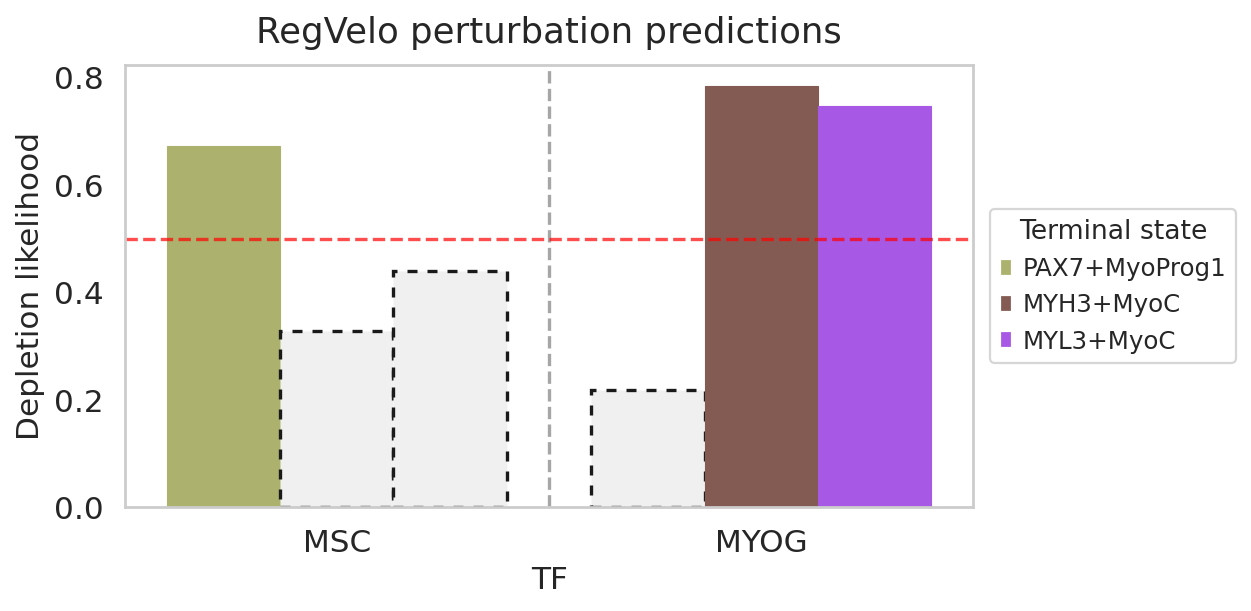

In [20]:
rgv.pl.cellfate_perturbation(adata=adata,
                             df=df,
                             fontsize=14,
                             figsize=(8,4),
                             legend_loc='center left',
                             legend_bbox=(1.02, 0.5),
                             color_label="leiden_R_celltype")

### Gene expression prediction under pertubation

We can further predict gene expression levels using `rgv_expression_fit` and compare the results to the control data. We demonstrate this using three representative genes and visualize the in-silico perturbation effects on their expression level.

In [21]:
Ms, Mu = vae_sr0.rgv_expression_fit(return_numpy=True, n_samples=30)
adata.layers["fit_s"] = Ms
adata.layers["fit_u"] = Mu
adata_perturb, vae_perturb = rgv.tl.in_silico_block_simulation(MODEL, adata, "MSC", effects=0)
adata_perturb.layers["fit_s"],adata_perturb.layers["fit_u"] = vae_perturb.rgv_expression_fit(n_samples=30)

INFO     File vae_sr0/model.pt already downloaded                                                                  


/tmp/ipykernel_2212498/1196197978.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')


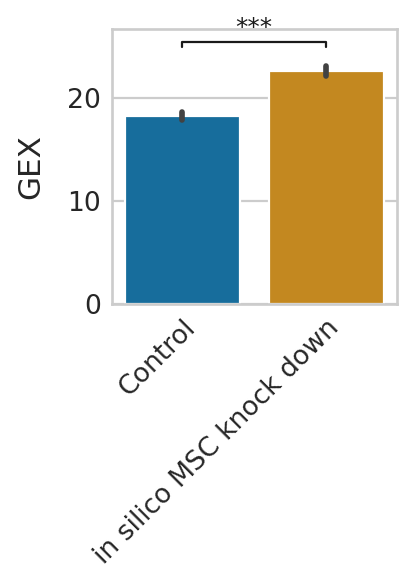

/tmp/ipykernel_2212498/1196197978.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')


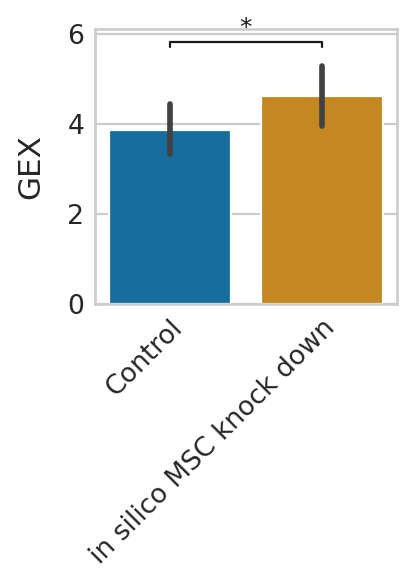

/tmp/ipykernel_2212498/1196197978.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')


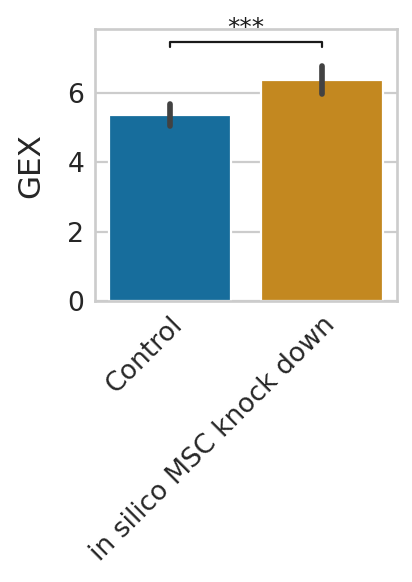

In [22]:
genes = ["MYOG", "MYH3", "TNNT1"]

for g in genes:
    df = pd.DataFrame(
        {
            "GEX": adata[:,g].layers["fit_s"].flatten().tolist() + adata_perturb[:,g].layers["fit_s"].flatten().tolist(),
            "Condition": ["Control"] * adata.shape[0] + ["in silico MSC knock down"] * adata.shape[0],
        }
    )
    df["GEX"] = df["GEX"] * np.max(adata[:,g].layers["spliced"])
    
    with mplscience.style_context():
        sns.set_style(style="whitegrid")
        fig, ax = plt.subplots(figsize=(3, 4))

        sns.barplot(data=df, x="Condition", y="GEX", palette="colorblind", ax=ax)
        
        ax.set_ylabel("GEX", labelpad=10)
        ax.set_xlabel("")
        ax.set_xticklabels(ax.get_xticklabels(), rotation = 45, ha = 'right', rotation_mode = 'anchor')
        plt.tight_layout(pad=2)
        ttest_res = ttest_ind(
            adata_perturb[:,g].layers["fit_s"].flatten().tolist(), 
            adata[:,g].layers["fit_s"].flatten().tolist(), 
            alternative="greater"
        )
        significance = rgv.mt.get_significance(ttest_res.pvalue)
        add_significance(
            ax=ax,
            left=0,
            right=1,
            significance=significance,
            lw=1,
            bracket_level=1.05,
            c="k",
            level=0,
        )
    
        plt.show()

### Short-term perturbation effect (Stochastic simulations of cell transitions)
To assess short-term perturbation effects, we compare the dynamics of the perturbed and unperturbed models using stochastic simulations of cell transitions. Transition matrices are computed using [CellRank](https://www.nature.com/articles/s41592-021-01346-6) based on the original and perturbed velocity fields.

For the initial state, we select cells annotated as *PAX3+MyoProg* and define the `start_indices` and `terminal_indices`, which are required for the `rgv.tl.markov_density_simulation` function. This function simulates trajectories across a velocity-based Markov chain and returns the absolute and relative number of visits to each terminal state, stored in `.obs['visits']` and `.obs['visits_dens']`, respectively.

To quantify the effect of perturbation, we apply `rgv.tl.simulated_density_diff`, which computes the average difference in visit counts between the perturbed and control systems for each terminal state. Negative values indicate a depletion of visits in the perturbed system relative to the control. The function also performs a paired t-test (`scipy.stats.ttest_rel`) to determine whether these differences are statistically significant. The resulting p-values are returned alongside the mean differences.

In [23]:
start_indices = np.where(adata.obs["leiden_R_celltype"].isin(["PAX3+MyoProg"]))[0]
terminal_indices = np.where(adata.obs["term_states_fwd"].isin(TERMINAL_STATES))[0]

vk = cr.kernels.VelocityKernel(adata).compute_transition_matrix()
ck = cr.kernels.ConnectivityKernel(adata).compute_transition_matrix()
combined_kernel = 0.8*vk + 0.2*ck
combined_kernel_t = combined_kernel.transition_matrix.A

Computing transition matrix using `'deterministic'` model


  0%|          | 0/12207 [00:00<?, ?cell/s]

Using `softmax_scale=10.3188`


  0%|          | 0/12207 [00:00<?, ?cell/s]

    Finish (0:00:06)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


In [24]:
method = "stepwise"

TF = "MSC"
adata_perturb = adata_pert_dict[TF]

vk_p = cr.kernels.VelocityKernel(adata_perturb).compute_transition_matrix()
ck_p = cr.kernels.ConnectivityKernel(adata_perturb).compute_transition_matrix()
combined_kernel_p = 0.8*vk_p + 0.2*ck_p
combined_kernel_pt = combined_kernel_p.transition_matrix.A

Computing transition matrix using `'deterministic'` model


  0%|          | 0/12207 [00:00<?, ?cell/s]

Using `softmax_scale=10.3111`


  0%|          | 0/12207 [00:00<?, ?cell/s]

    Finish (0:00:06)
Computing transition matrix based on `adata.obsp['connectivities']`
    Finish (0:00:00)


In [25]:
total_simulations = rgv.tl.markov_density_simulation(adata, 
                                                     combined_kernel_t, 
                                                     start_indices, 
                                                     terminal_indices, 
                                                     TERMINAL_STATES,
                                                     method=method)

In [26]:
_ = rgv.tl.markov_density_simulation(adata_perturb, 
                                     combined_kernel_pt, 
                                     start_indices, 
                                     terminal_indices, 
                                     TERMINAL_STATES,
                                     method=method)

In [27]:
dd_score, dd_sig = rgv.tl.simulated_visit_diff(adata, adata_perturb, TERMINAL_STATES)
print(dd_score)
print(dd_sig)

[-137.39999999999998, 2990.7333333333345, 0.5666666666666664]
[8.709956977564526e-05, 0.00047703174620153616, 0.6583323305783767]


We further use the function `rgv.pl.simulated_density_diff` to visualize short-term perturbation effects by analyzing the number of simulated visits to each terminal cell in both the perturbed and unperturbed systems. For each terminal cell, we compute the difference in the number of visits between the perturbed and control simulations. To account for stochastic variability across simulations, this difference is scaled by $1/\sqrt{\text{\# total simulations}}$. The resulting scaled differences are then passed through a sigmoid function and stored in `adata.obs['visits_diff']`. These scores are then smoothed over neighboring cells to produce a spatially coherent signal, stored in `adata.obs['visits_diff_smoothed']`. Values below 0.5 indicate a relative depletion of visits to the corresponding terminal cell under perturbation.

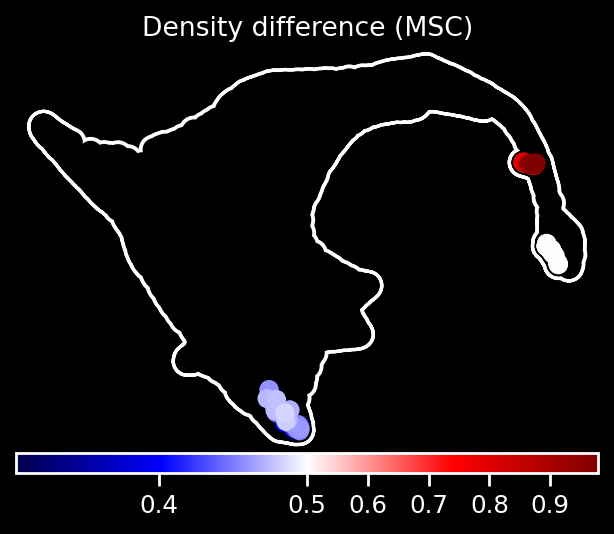

In [28]:
rgv.pl.simulated_visit_diff(adata, 
                            adata_perturb, 
                            TERMINAL_STATES, 
                            total_simulations,
                            basis="draw_graph_fa", 
                            color_map="seismic",
                            title="Density difference (MSC)")